# **Import Necessary Libraries**

In [2]:
import cv2
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import tensorflow as tf
import os

!pip install opencv-python-headless

# **1. HOG (Histogram of Oriented Gradients) Object Detection**

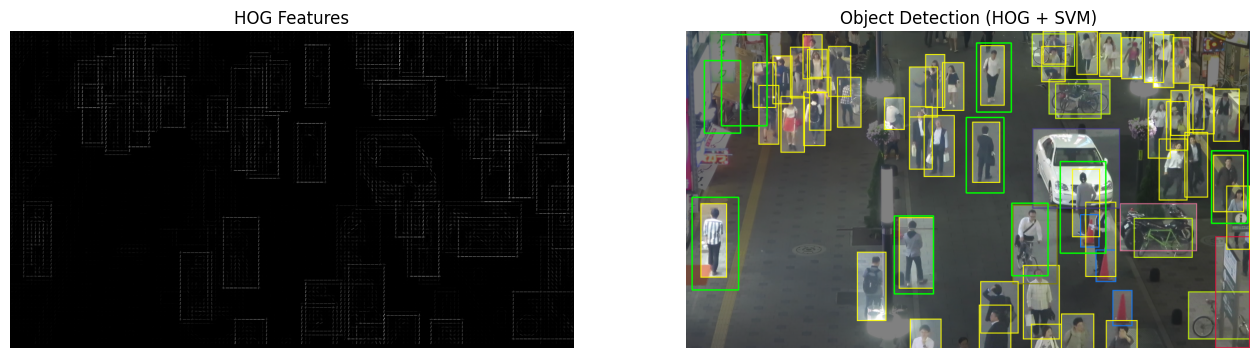

In [3]:
# Load an image
image = cv2.imread('/content/Image.png')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply HOG descriptor to visualize HOG features
features, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True)

# Initialize the HOG descriptor with SVM-based pedestrian detector in OpenCV
hog_detector = cv2.HOGDescriptor()
hog_detector.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Detect objects (pedestrians in this case)
rects, weights = hog_detector.detectMultiScale(image, winStride=(8, 8), padding=(8, 8), scale=1.05)

# Draw bounding boxes on the original image
for (x, y, w, h) in rects:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the HOG image
plt.figure(figsize=(16, 8))

# Plot HOG feature image
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("HOG Features")
plt.imshow(hog_image, cmap='gray')

# Plot the image with detected objects
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("Object Detection (HOG + SVM)")
hog_result = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(hog_result)

# Show both plots
plt.show()

# **2. YOLO (You Only Look Once) Object Detection**

In [4]:
# Download YOLOv3 weights
!wget https://pjreddie.com/media/files/yolov3.weights

# Download YOLOv3 config file
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

# Download COCO names (class labels)
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names


--2024-10-29 00:15:01--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  14.2MB/s    in 22s     

2024-10-29 00:15:24 (10.5 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-10-29 00:15:24--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2

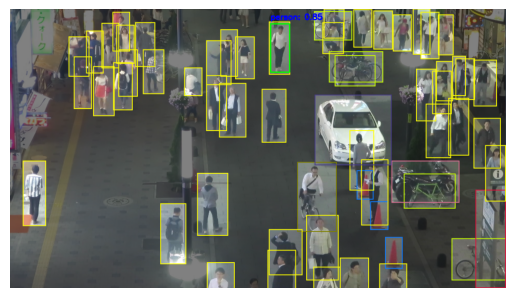

In [5]:
# Load YOLO model and configuration
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

# Extract the output layer names from the YOLO model
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Load class names from COCO dataset
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Load the image
image = cv2.imread('/content/Image.png')
height, width, channels = image.shape

# Preprocess the image for YOLO detection
blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)

# Perform the forward pass and get the output
outs = net.forward(output_layers)

# Process the detections and draw bounding boxes with labels
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        if confidence > 0.5:
            # Get bounding box coordinates
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            # Draw the bounding box
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Get the label and display it on the image
            label = f"{classes[class_id]}: {confidence:.2f}"
            cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

yolo_result = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Visualize the detection result
plt.imshow(yolo_result)
plt.axis('off')  # Hide axes
plt.show()

# **3. SSD (Single Shot MultiBox Detector) with TensorFlow**

In [6]:
!pip install tensorflow
# Download the SSD MobileNet V2 model
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# Extract the downloaded model
!tar -xvzf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# Download the mscoco_label_map.pbtxt file from GitHub
!wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt


--2024-10-29 00:15:32--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.142.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M   126MB/s    in 0.2s    

2024-10-29 00:15:33 (126 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x32

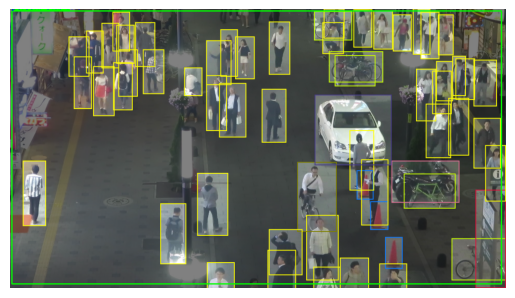

In [7]:
import re

# Parse the label map from TensorFlow's pbtxt file
def load_label_map(path):
    category_index = {}
    with open(path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if "id" in line:
                # Extract the class ID
                class_id = int(re.search(r'id: (\d+)', line).group(1))
            if "display_name" in line:
                # Extract the class label
                label = re.search(r'display_name: "(.*)"', line).group(1)
                category_index[class_id] = label
    return category_index

# Load the correct label map
label_map_path = 'mscoco_label_map.pbtxt'
LABEL_MAP = load_label_map(label_map_path)

# Load pre-trained SSD model from TensorFlow's object detection API
ssd_model = tf.saved_model.load('ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model')

# Load the image
image_path = '/content/Image.png'
image_np = cv2.imread(image_path)
image_height, image_width, _ = image_np.shape

# Convert image to tensor
input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]

# Run the SSD model
detections = ssd_model(input_tensor)

# Process detections and visualize bounding boxes for SSD
num_detections = int(detections['num_detections'][0])
detection_boxes = detections['detection_boxes'][0].numpy()
detection_scores = detections['detection_scores'][0].numpy()
detection_classes = detections['detection_classes'][0].numpy().astype(np.int32)

# Set a confidence threshold for drawing boxes (you can lower it further if needed)
confidence_threshold = 0.3

for i in range(num_detections):
    if detection_scores[i] > confidence_threshold:
        # Get bounding box coordinates
        ymin, xmin, ymax, xmax = detection_boxes[i]
        left, right, top, bottom = (xmin * image_width, xmax * image_width,
                                    ymin * image_height, ymax * image_height)

        # Draw bounding box
        cv2.rectangle(image_np, (int(left), int(top)), (int(right), int(bottom)), (0, 255, 0), 2)

        # Get the class ID and label
        class_id = detection_classes[i]
        class_label = LABEL_MAP.get(class_id, 'N/A')  # Default to 'N/A' if class not found

        # Draw the label on top of the bounding box
        label = f'{class_label}: {int(detection_scores[i] * 100)}%'
        label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        label_top = max(int(top) - label_size[1], 0)
        cv2.rectangle(image_np, (int(left), label_top), (int(left) + label_size[0], int(top)), (0, 255, 0), -1)  # Box for label
        cv2.putText(image_np, label, (int(left), int(top) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

ssd_result = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

# Display SSD detection results using matplotlib (plt)
image_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)  # Convert to RGB for plt
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()


# **Compare the results of SSD and YOLO Model**

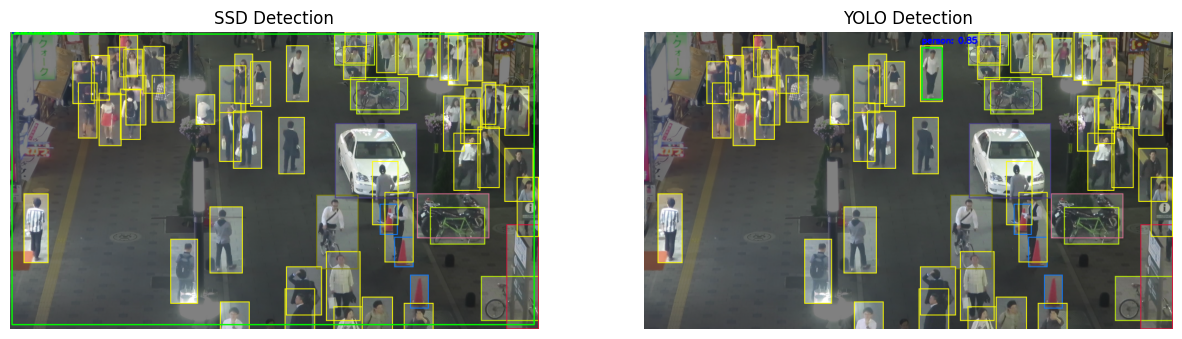

In [8]:
# Create a plot to display SSD and YOLO results side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# SSD result on the left
ax1.imshow(ssd_result)
ax1.set_title('SSD Detection')
ax1.axis('off')

# YOLO result on the right
ax2.imshow(yolo_result)
ax2.set_title('YOLO Detection')
ax2.axis('off')

# Display both
plt.show()


# **4. Traditional vs. Deep Learning Object Detection Comparison**

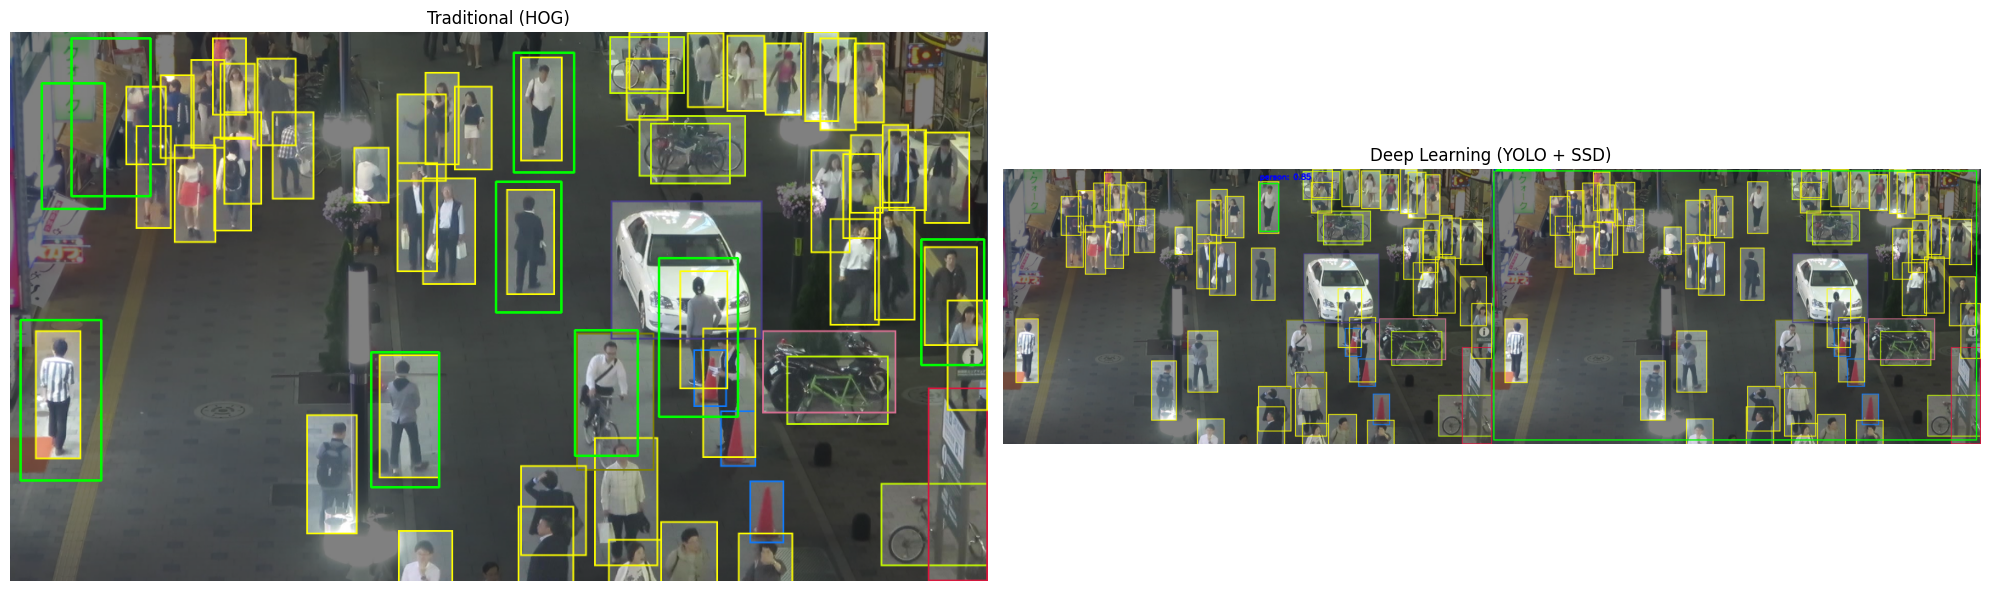

In [9]:
deep_learning_result = np.concatenate((yolo_result, ssd_result), axis=1)
# Create a plot to display HOG and Deep Learning (YOLO + SSD) side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# HOG result on the left with the title "Traditional"
ax1.imshow(hog_result)
ax1.set_title('Traditional (HOG)')
ax1.axis('off')

# YOLO + SSD result on the right with the title "Deep Learning"
ax2.imshow(deep_learning_result)
ax2.set_title('Deep Learning (YOLO + SSD)')
ax2.axis('off')

# Display both
plt.tight_layout()
plt.show()